In [1]:
#################################################################
from sklearn.model_selection import train_test_split
import librosa
from librosa import display
import IPython.display as ipd
import os
import pandas as pd
import glob 
import time
from numpy import array
import numpy as np
import joblib
##################################################################
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from scipy import signal
from sklearn.metrics import classification_report, confusion_matrix
from math import floor
from sklearn.tree import DecisionTreeClassifier
import itertools

Using TensorFlow backend.


In [2]:
## loading an audio file for finding audio sampling rate
data, sampling_rate = librosa.load('dataset/speech dataset/03-01-03-01-01-01-11.wav')
print("My sampling rate = ", sampling_rate)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\dataset\\speech dataset\\03-01-03-01-01-01-11.wav'

In [ ]:
path = 'dataset/speech dataset/'

##lst is list which contains speech data set 
lst = []
####lst is list which contains song data set 
lstmusic = []

## The model is trained on speech data and evaluated on song data
start_time = time.time()

##loading speech dataset into lst
for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        
        file = int(file[7:8]) - 3
        ##file is numerical value (file == 0 if emotion is happy) (file == 1 if emotion is sad) (file == 2 if emotion is angry)
        ##arr is speech file in array form
        arr = X, file
        lst.append(arr)
      except ValueError:
        continue       
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

In [ ]:
path = 'dataset/song dataset/'    
##loading speech dataset into lst
for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        Xmusic, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        filemusic = int(file[7:8]) - 3
        ##file is numerical value (file == 0 if emotion is happy) (file == 1 if emotion is sad) (file == 2 if emotion is angry)
        ##arr is music file in array form
        arrmusic = Xmusic, filemusic
        lstmusic.append(arrmusic)
      except ValueError:
        continue

In [ ]:
lsts = []
## this code basically make the length of all the speech&music data equal 
min_size = len(lst[0][0])
for i in range(len(lst)):
    if min_size > len(lst[i][0]):
        min_size = len(lst[i][0])
      
print("The size on input speech signals", min_size)
for i in range(len(lst)):
    lsts.append([lst[i][0][0:min_size],lst[i][1]])
    
lstmusics = []
for i in range(len(lstmusic)):
    lstmusics.append([lstmusic[i][0][0:min_size],lstmusic[i][1]]) 

In [ ]:
## permutation is applied on data for randomization
np.random.seed(42)
lst = np.random.permutation(lst)

## X is speech array y is emotional state (y==0 if emotion is happy) (y==1 if emotion is sad) (y==2 if emotion is angry))
X, y = zip(*lsts)
Xmusic, ymusic = zip(*lstmusics)


X = np.asarray(X)
y = np.asarray(y)
Xmusic = np.asarray(Xmusic) ## converting list to array since 
ymusic = np.asarray(ymusic) ## converting list to array since 
X_musiccnn = np.expand_dims(Xmusic, axis=2)
X.shape, y.shape

In [10]:
## Saving joblib files to not load them again with the loop above 
## Basically this just for saving loading time
X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = 'dataset/Joblib/'
    
savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [46]:
# Loading saved models
X = joblib.load('dataset/Joblib/X.joblib')
y = joblib.load('dataset/Joblib/y.joblib')

In [47]:
## Training data over SVM decision tree classifier 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [102]:
## Function for plotting confusion matrix 
def plot_confusion_matrix(cm, title, cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(np.arange(3), ('happy', 'sad', 'angry'))
    ax = plt.gca()
    plt.yticks(np.arange(3), ('happy', 'sad', 'angry'))

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

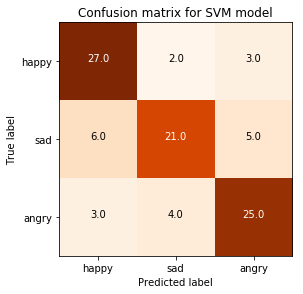

In [103]:
## Prediction from trained SVM model
predictions_svm = dtree.predict(Xmusic)
cm_SVM = confusion_matrix(ymusic, predictions_svm)

## Confusion matrix of SVM classifier
plot_confusion_matrix(cm_SVM, title='Confusion matrix for SVM model')

In [52]:

model = Sequential()
#########################################################
model.add(Conv1D(filters=200, kernel_size=200, strides=50, padding='same', use_bias=True, bias_initializer='zeros',input_shape=(min_size,1)))
#########################################################
model.add(Activation('relu'))
#########################################################
model.add(Dropout(0.1))
#########################################################
model.add(MaxPooling1D(pool_size=(10)))
#########################################################
model.add(Flatten())
#########################################################
model.add(Dense(200))
#########################################################
model.add(Activation('softmax'))
#########################################################
opt = keras.optimizers.rmsprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)

#model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

[0 1 0 2 1 2 0 0 1 2 0 2 2 0 2 0 0 2 0 2 1 2 1 0 0 2 2 1 2 2 0 1 0 2 1 0 2
 0 0 2 1 0 0 0 0 1 1 1 0 0 0 2 0 0 2 0 2 1 1 0 1 2 1 2 1 0 2 0 1 0 2 2 0 2
 1 1 1 1 2 1 0 1 1 2 1 1 1 1 2 0 2 2 1 0 1 0 0 1 0 0 1 2 0 1 0 1 0 1 2 0 2
 2 2 1 1 1 0 2 1 1 1 1 1 1 2 2 0 1 0 2 0 1 0 0 1 0 2 0 2 2 1 0 1 0 2 2 0 1
 2 0 2 2 0 1 1 1 1 1 2 0 1 2 1 2 0 2]
Train on 386 samples, validate on 166 samples
Epoch 1/50
386/386 [==============================] - 22s 58ms/step - loss: 4.4329 - acc: 0.3238 - val_loss: 3.4747 - val_acc: 0.4157
Epoch 2/50
386/386 [==============================] - 4s 11ms/step - loss: 2.4578 - acc: 0.3316 - val_loss: 1.9373 - val_acc: 0.3855
Epoch 3/50
386/386 [==============================] - 4s 11ms/step - loss: 1.4377 - acc: 0.3575 - val_loss: 1.3226 - val_acc: 0.3072
Epoch 4/50
386/386 [==============================] - 4s 11ms/step - loss: 1.1173 - acc: 0.3912 - val_loss: 1.1014 - val_acc: 0.4398
Epoch 5/50
386/386 [==============================] - 4s 11ms/step - loss: 1.0141 -

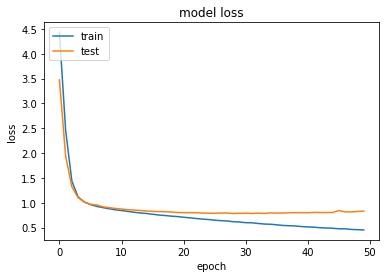

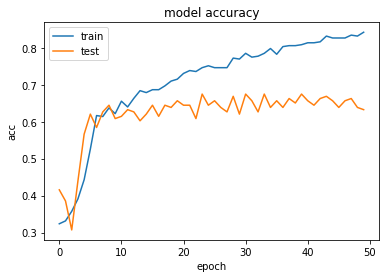

In [53]:
#training
for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40+i)
    print(y_test)
    x_traincnn = np.expand_dims(X_train, axis=2)
    x_testcnn = np.expand_dims(X_test, axis=2)
    cnnhistory=model.fit(x_traincnn, y_train, batch_size=15, epochs=50,validation_data=(x_testcnn, y_test))
    plt.plot(cnnhistory.history['loss'])
    plt.plot(cnnhistory.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(cnnhistory.history['acc'])
    plt.plot(cnnhistory.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Time taken in prediction : 5.014129877090454


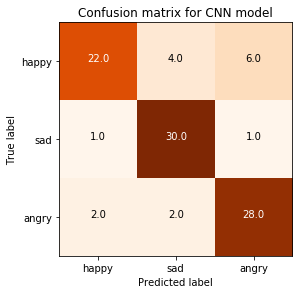

In [156]:
## Predictions from trained model
start = time.time()
predictions = model.predict_classes(X_musiccnn)
end = time.time()
print("Time taken in prediction :", end-start)
cm_CNN = confusion_matrix(ymusic, predictions)
## Confusion matrix for CNN
plot_confusion_matrix(cm_CNN, title='Confusion matrix for CNN model')

In [113]:
## Extracting weights of convolutional layerof trained model
Wc = model.layers[0].get_weights()[0]
# print(f.shape)
k = np.transpose(Wc)
# print(k.shape)

Text(0, 0.5, 'frequency (Hz)')

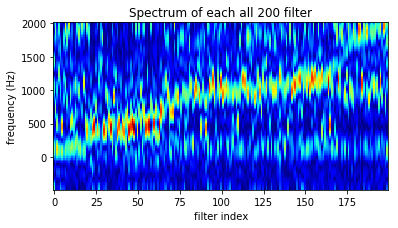

In [117]:
## Network analysis finding spectogram of filters of convolutional layers

pi = 1

ms = 100
h_max = [[0 for x in range(ms)] for y in range(200)] 
for l in range(200):
    w, h = signal.freqz(k[l][0],worN=1024)
    w, h = w[0:ms], h[0:ms]
    h_max[l][0] = w[np.argmax(h)]/pi*sampling_rate/2
    h_max[l][1:] = abs(h)

h_max = np.asarray(h_max)
h_max=h_max[np.argsort(h_max[:,0])]
x = np.delete(h_max, (0), axis=1)

x = np.rot90(x)
fig, ax1 = plt.subplots(1,1)
ax1.imshow(x, cmap='jet', interpolation='nearest')
ax1.set_yticklabels(['', 2000,1500,1000,500,0])
title = 'Spectrum of each all 200 filter'
plt.title(title)
plt.xlabel('filter index')
plt.ylabel('frequency (Hz)')


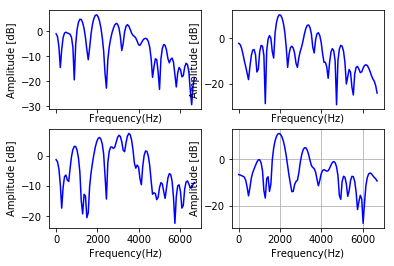

In [155]:
## code for finding frequency response of filters in convolutional layer
fi = 150 ## filter index of which fourire transform is to be calculated
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True)
for ind in range(4):
    frequency_set = [100,10,50,150] ## fiter index for which frequency response is to be plotted
    fi = frequency_set[ind]
    w, h = signal.freqz(k[fi][0])
    w=w[0:100] ## ignoring frequency responce at very high frequencies
    h=h[0:100] ## ignoring frequency responce at very high frequencies   
    a = [[0,0],[0,1],[1,0],[1,1]]

    axes[a[ind][0],a[ind][1]].plot(w/pi*sampling_rate/2, 20*np.log10(abs(h)), 'b')
    axes[a[ind][0],a[ind][1]].set_ylabel('Amplitude [dB]')
    axes[a[ind][0],a[ind][1]].set_xlabel('Frequency(Hz)')

plt.grid()
plt.axis('tight')
plt.show()